In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

## Data generation
create normally distributed data

In [3]:
data = np.random.normal(loc=3, scale=0.5, size=1000)
data[:10]

array([3.61664301, 3.2607841 , 2.47055665, 3.09860486, 3.32199395,
       2.99157478, 1.85982165, 2.58921357, 3.1394505 , 3.55870093])

/home/lukas/.pyenv/versions/3.6.3/envs/mcmc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


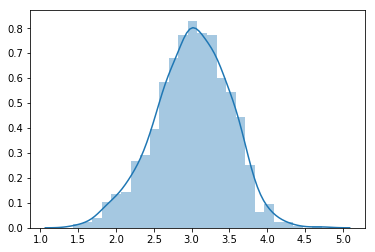

In [4]:
sns.distplot(data)

## Generator of normal PDF functions

/home/lukas/.pyenv/versions/3.6.3/envs/mcmc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


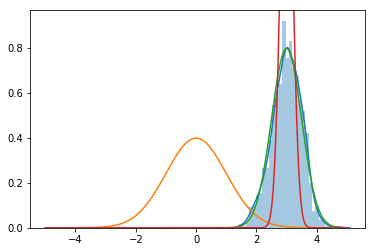

In [5]:
def get_norm_pdf(loc, scale):
    def pdf(x):
        return norm.pdf(x, loc=loc, scale=scale)
    return pdf

def plot_pdf(pdf, minx=-5, maxx=5):
    X = np.array([x/100 for x in range(minx*100, maxx*100)])
    Y = np.array([pdf(x) for x in X])
    plt.plot(X, Y)
    
sns.distplot(data, bins=30)
n1 = get_norm_pdf(0, 1)
n2 = get_norm_pdf(3, 0.5)
n3 = get_norm_pdf(3, 0.2)
plot_pdf(n1)
plot_pdf(n2)
plot_pdf(n3)


## likelihood

In [6]:
def likelihood(pdf, data):
    probabilities = [pdf(x) for x in data]
    return np.prod(probabilities)


def log_likelihood(pdf, data):
    probabilities = [pdf(x) for x in data]
    return np.sum(np.log(probabilities))

likelihood works for small data:

In [7]:
print(likelihood(n1, data[:10]))
print(likelihood(n2, data[:10]))
print(likelihood(n3, data[:10]))

1.0298690162804422e-24
0.0005299718878055655
4.50948624159221e-12


we will underflow for bigger data:

In [8]:
print(likelihood(n1, data[:1000]))
print(likelihood(n2, data[:1000]))
print(likelihood(n3, data[:1000]))


0.0
1.2377708549781803e-307
0.0


thats why we use log likelihood:

In [9]:
print(log_likelihood(n1, data[:1000]))
print(log_likelihood(n2, data[:1000]))
print(log_likelihood(n3, data[:1000]))


-5562.810950379038
-706.6803114849508
-2315.056613521969


## Searches

helper function that will evaluate data likelihood for given normal dist params

In [10]:
def loglike_for_params(loc, scale, data=data):
    pdf = get_norm_pdf(loc, scale)
    return log_likelihood(pdf, data)

print(loglike_for_params(0, 1))
print(loglike_for_params(2.9, 0.4))
print(loglike_for_params(3, 0.5))



-5562.810950379038
-790.2139198234313
-706.6803114849508


### grid search

In [11]:
def grid_search(loc_range=(-2, 6), scale_range=(0.2, 2), steps=10):
    loc_min, loc_max = loc_range
    locs = np.linspace(loc_min, loc_max, steps)
    
    scale_min, scale_max = scale_range
    scales = np.linspace(scale_min, scale_max, steps)
    
    
    for loc in locs:
        for scale in scales:
            loglike = loglike_for_params(loc, scale)
            yield {
                'loc': loc, 
                'scale': scale, 
                'loglike': loglike,
            }
            
grid_df = pd.DataFrame(grid_search())[['loc', 'scale', 'loglike']]
grid_df.head(5)
            

,loc,scale,loglike
0,-2.0,0.2,-315800.480675
1,-2.0,0.4,-79125.392815
2,-2.0,0.6,-35573.777360
3,-2.0,0.8,-20476.481235
4,-2.0,1.0,-13578.577735


In [12]:
grid_df.sort_values(by='loglike', ascending=False).head(5)

,loc,scale,loglike
62,3.333333,0.6,-889.085125
63,3.333333,0.8,-966.341853
61,3.333333,0.4,-1084.835287
64,3.333333,1.0,-1092.088531
53,2.444444,0.8,-1131.611997


In [13]:
grid_df.pivot('loc', 'scale', 'loglike')

scale,0.2,0.4,0.6000000000000001,0.8,1.0,1.2,1.4000000000000001,1.6,1.8,2.0
loc,,,,,,,,,,
-2.000000,-315800.480675,-79125.392815,-35573.777360,-20476.481235,-13578.577735,-9892.676203,-7714.410363,-6334.113726,-5414.021248,-4776.995514
-1.111111,-214390.726274,-53772.954215,-24306.026871,-14138.371585,-9522.187559,-7075.738580,-5644.823538,-4749.586313,-4162.048972,-3762.897970
-0.222222,-132734.058292,-33358.787219,-15233.063762,-9034.829836,-6255.920840,-4807.497803,-3978.360926,-3473.700876,-3153.941959,-2946.331290
0.666667,-70830.476731,-17882.891829,-8354.888033,-5165.855989,-3779.777578,-3087.953871,-2715.022527,-2506.457414,-2389.700212,-2327.295475
1.555556,-28679.981589,-7345.268043,-3671.499684,-2531.450042,-2093.757772,-1917.106784,-1854.808341,-1847.855928,-1869.323729,-1905.790523
2.444444,-6282.572867,-1745.915863,-1182.898715,-1131.611997,-1197.861423,-1294.956541,-1397.718367,-1497.896416,-1592.812510,-1681.816436
3.333333,-3638.250565,-1084.835287,-889.085125,-966.341853,-1092.088531,-1221.503144,-1343.752605,-1456.578880,-1560.166555,-1655.373213
4.222222,-20747.014683,-5362.026317,-2790.058916,-2035.639611,-1776.439096,-1696.746592,-1692.911057,-1723.903320,-1771.385866,-1826.460854
5.111111,-57608.865220,-14577.488951,-6885.820087,-4339.505269,-3250.913117,-2720.686884,-2445.193721,-2299.869734,-2226.470440,-2195.079360


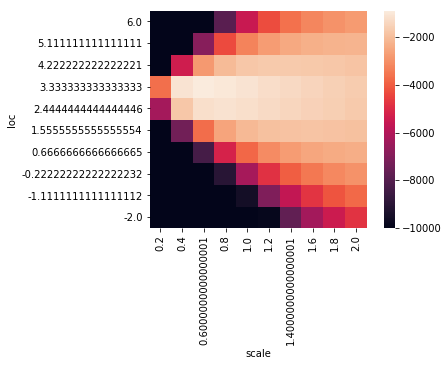

In [14]:
def plot_heatmap(df):
    ax = sns.heatmap(df.pivot('loc', 'scale', 'loglike'), vmin=-10000, square=True)
    ax.invert_yaxis()
plot_heatmap(grid_df)

### random search

In [15]:
def random_search(loc_range=(-2, 6), scale_range=(0.2, 2), samples=100):
    loc_min, loc_max = loc_range
    
    scale_min, scale_max = scale_range
    
    for _ in range(samples):
        loc = np.random.uniform(loc_min, loc_max)
        scale = np.random.uniform(scale_min, scale_max)
        loglike = loglike_for_params(loc, scale)
        yield {
            'loc': loc, 
            'scale': scale, 
            'loglike': loglike,
        }
            
loglikes_df = pd.DataFrame(random_search())[['loc', 'scale', 'loglike']]
loglikes_df.head(5)

,loc,scale,loglike
0,0.121406,1.731745,-2897.262055
1,4.143676,1.886592,-1768.702019
2,1.379375,1.054295,-2272.901014
3,-1.328049,1.097278,-8918.911718
4,4.028842,0.884790,-1615.804820


here we see that by using random instead of grid, we are already gaining little bit of better estimates:

In [16]:
loglikes_df.sort_values(by='loglike', ascending=False).head(5)

,loc,scale,loglike
63,2.876003,0.725012,-842.571187
84,2.905348,0.821976,-908.566175
96,2.660270,1.081457,-1151.673587
92,3.643769,0.715055,-1214.021753
97,2.617046,0.399645,-1232.494117


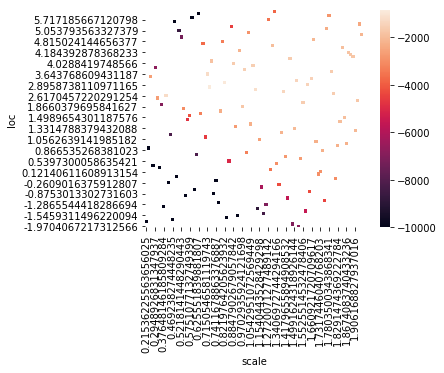

In [17]:
plot_heatmap(loglikes_df)

### random walk

In [18]:
def random_walk(loc_range=(-2, 6), scale_range=(0.2, 2), steps=100, extent_ratio=0.01):
    loc_min, loc_max = loc_range
    loc_step_extent = (loc_max - loc_min) * extent_ratio
    
    scale_min, scale_max = scale_range
    scale_step_extent = (scale_max - scale_min) * extent_ratio
    
    best_loc = np.random.uniform(loc_min, loc_max)
    best_scale = np.random.uniform(scale_min, scale_max)
    best_loglike = loglike_for_params(best_loc, best_scale)
    for _ in range(steps):
        
        new_loc = best_loc + np.random.normal(scale=loc_step_extent)
        new_scale = best_scale + np.random.normal(scale=scale_step_extent)
        new_loglike = loglike_for_params(new_loc, new_scale)
        if new_loglike > best_loglike:
            best_loglike = new_loglike
            best_loc = new_loc
            best_scale = new_scale
            
        yield {
            'loc': new_loc, 
            'scale': new_scale, 
            'loglike': new_loglike,
        }
        
loglikes_df = pd.DataFrame(random_walk())[['loc', 'scale', 'loglike']]
loglikes_df.head(5)

,loc,scale,loglike
0,4.004501,0.974954,-1542.486695
1,3.965968,0.985171,-1500.718862
2,3.946010,0.988662,-1480.691015
3,3.872349,1.003545,-1412.835847
4,3.913917,0.995340,-1449.887539


In [19]:
loglikes_df.sort_values(by='loglike', ascending=False).head(5)

,loc,scale,loglike
97,2.948333,0.561800,-728.757490
98,3.081876,0.556606,-729.827909
99,3.032910,0.584434,-734.629630
94,3.013895,0.588958,-736.090779
95,2.965873,0.586386,-737.274616


### plot the walk

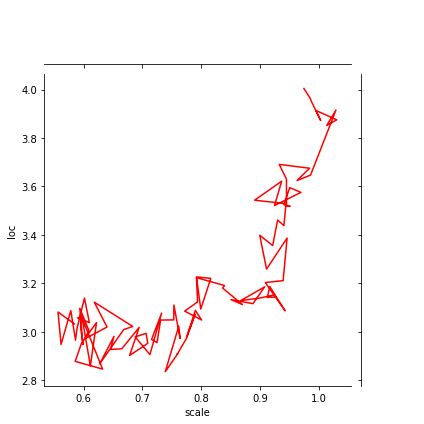

In [22]:
# TODO there must be better way to plot this
g = sns.JointGrid(x=loglikes_df['scale'], y=loglikes_df['loc'])
g.plot_joint(plt.plot, color="r")

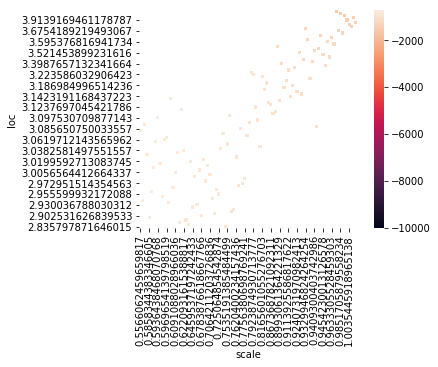

In [21]:
ax = plot_heatmap(loglikes_df)
